# Multiclass perceptron from scratch


In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Multi-class Extension of the Perceptron Algorithm ##
# 1 vs all strategy: train a classifier for each class. 

# params
class SingleClassifier:
    def __init__(self, data, thresh, target, features):
        self.df = data
        self.thresh = thresh
        self.target = target
        self.features = features
        
        if "bias" not in self.features:
            self.features.append("bias")
        

    def train(self, train_df, ycol, weights):
        '''
        train(train_df, 'y', weights)
        '''
        for index, row in train_df.iterrows():
            x = row[self.features].to_numpy()
            y_true = row[ycol]

            # print(x, weights)
            y_hat = np.dot(x, weights)

            if y_hat * y_true <= self.thresh: 
                weights = np.add(weights, np.multiply(int(y_true), x))
            
        return weights 


    def predict(self, test_df, weights):
        res = []

        for index, row in test_df.iterrows():
            y_hat = np.dot(row[self.features].to_numpy(), weights)
            prediction = -1
            if y_hat > self.thresh:
                prediction = 1

            res.append({"Prediction": prediction, "Confidence": y_hat, "Actual": row['y'], "Actual name": row['variety']})

        return pd.DataFrame(res)

def preprocess(df, ycol, ycolname):
    '''
    preprocess(df, 'Setosa', 'variety')
    '''
    ## convert to bin dataset
    working_df = df.copy(deep=True)
    working_df.loc[working_df[ycolname] == ycol, 'y'] = 1
    working_df.loc[working_df[ycolname] != ycol, 'y'] = -1
    working_df['bias'] = 1

    return working_df

In [6]:
df = pd.read_csv("iris.csv")

def multiClass(iter, split):

    ret = []

    flower_weights = {
        'Setosa': [0 for i in range(5)],
        'Versicolor': [0 for i in range(5)],
        'Virginica': [0 for i in range(5)],
    }

    targets = ['Setosa', 'Versicolor', 'Virginica']
    features = ['sepal.length', 'sepal.width', 'petal.length', 'petal.width']
    thresh = 0

    for i in range(iter):
        # train test split
        train_df = df.groupby('variety', group_keys=False).apply(lambda x: x.sample(frac=split, random_state=1)).sample(frac=1, random_state=10)
        test_df = df.drop(train_df.index).sample(frac=1, random_state=1)

        # train on the train df
        res = {}
        store = {}
        for target in targets: 
            classifier = SingleClassifier(train_df, 0, target, features.copy())
            train_df_target = preprocess(train_df, target, 'variety')
            test_df_target = preprocess(test_df, target, 'variety')

            # weights = np.array([0 for i in range(len(features) + 1)]) # + 1 for bias
            weights = flower_weights[target]
            weights = classifier.train(train_df_target, 'y', weights)
            preds = classifier.predict(test_df_target, weights)
            flower_weights[target] = weights
            res[target] = {"preds": preds}
            acc = len(preds.loc[preds['Prediction'] == preds['Actual']]) / len(preds)
            # print(f"Accuracy of {target}: {acc}")
            store[target] = acc

        concat = pd.DataFrame()
        for k in res:
            temp = res[k]['preds'][['Confidence']]
            temp = temp.rename(columns={"Confidence": f"{k}"})
            concat = pd.concat([concat, temp], axis=1)

        concat = pd.concat([concat, res[k]['preds']['Actual name']], axis=1)
        concat['Predicted'] = concat[['Setosa', 'Versicolor', 'Virginica']].idxmax(axis=1)

        acc = len(concat.loc[concat['Predicted'] == concat['Actual name']]) / len(concat)
        # print(f"Total acc: {acc}")
        store["Total"] = acc

        ret.append(store)

    return ret

In [7]:
# training on a 2/3:1/3 train/test split of the data for 10 iterations
res = pd.DataFrame(multiClass(iter=10, split=0.66))

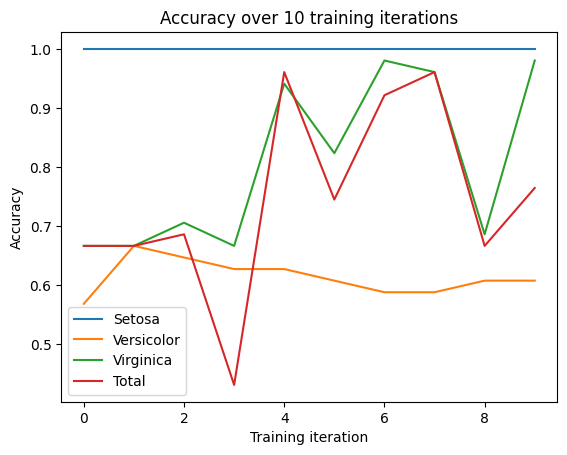

,Setosa,Versicolor,Virginica,Total
0,1.0,0.568627,0.666667,0.666667
1,1.0,0.666667,0.666667,0.666667
2,1.0,0.647059,0.705882,0.686275
3,1.0,0.627451,0.666667,0.431373
4,1.0,0.627451,0.941176,0.960784
5,1.0,0.607843,0.823529,0.745098
6,1.0,0.588235,0.980392,0.921569
7,1.0,0.588235,0.960784,0.960784
8,1.0,0.607843,0.686275,0.666667
9,1.0,0.607843,0.980392,0.764706


In [9]:
# plotting training curves
plt.plot(res.index, res['Setosa'], label='Setosa')
plt.plot(res.index, res['Versicolor'], label='Versicolor')
plt.plot(res.index, res['Virginica'], label='Virginica')
plt.plot(res.index, res['Total'], label='Total')

plt.title('Accuracy over 10 training iterations')
plt.xlabel('Training iteration')
plt.ylabel('Accuracy')

plt.legend()
plt.show()
res